# ATLAS Data Compression: Data Exploration

This notebook explores the structure and properties of ATLAS DAOD_PHYSLITE files, comparing original and compressed versions. It includes file size checks, data type analysis, and statistical comparisons of physics variables.

## Table of Contents

1. [Import Required Libraries](#import-required-libraries)
2. [Define File Paths](#define-file-paths)
3. [File Size Utilities](#file-size-utilities)
4. [Data Type Analysis](#data-type-analysis)
5. [Compare Data Type Statistics](#compare-data-type-statistics)
6. [DataFrame Comparison and LaTeX Output](#dataframe-comparison-and-latex-output)
7. [Grouped Metrics and Averages](#grouped-metrics-and-averages)
8. [Branch Structure Exploration](#branch-structure-exploration)
9. [Electron $p_T$ Distribution Comparison](#electron-pt-distribution-comparison)
10. [Log-Scaled Distribution Analysis](#log-scaled-distribution-analysis)
11. [Multi-Variable Distribution Comparison](#multi-variable-distribution-comparison)
12. [Peak Detection in Absolute Differences](#peak-detection-in-absolute-differences)
13. [Scatter Plot of Original vs Compressed](#scatter-plot-of-original-vs-compressed)
14. [Statistical Summary of Differences](#statistical-summary-of-differences)
15. [Distribution Metrics and Divergences](#distribution-metrics-and-divergences)
16. [Histogram Residuals](#histogram-residuals)
17. [Empirical CDF Comparison](#empirical-cdf-comparison)

## 1. Import Required Libraries

Import all necessary Python libraries for data analysis, plotting, and ROOT file handling.

In [29]:
# Import basic libraries
import copy # copy variables
import os   # manage paths
from collections import defaultdict
from tabulate import tabulate
import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import tqdm # progress bars
import atlasopenmagic as atom # ATLAS Open Data package
import numpy as np
import pandas as pd # dataframes

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import skew, kurtosis, entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon
from statsmodels.distributions.empirical_distribution import ECDF
pd.options.display.float_format = '{:,.6f}'.format

## 2. Define File Paths

Specify the locations of original and compressed DAOD_PHYSLITE files for both real and simulated data.

In [23]:
# Base output directories (match your Bash script)
base_compressed_real = "/eos/user/y/yolanney/compressed_files/real"
base_compressed_sim  = "/eos/user/y/yolanney/compressed_files/sim"

# Full original paths
real_uncompressed = [
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1",
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6482/data23_13p6TeV.00456749.physics_Main.deriv.DAOD_PHYSLITE.r15774_p6304_p6482/DAOD_PHYSLITE.41588921._000002.pool.root.1"
]

sim_uncompressed = [
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6490/mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_r13146_p6490/DAOD_PHYSLITE.41651753._000007.pool.root.1",
    "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6491/mc23_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r15540_r15516_p6491/DAOD_PHYSLITE.41633384._000941.pool.root.1"
]

filename = "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1"
compressed_filename = "/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41578717._000256.pool.root_dl10_compressed.root"

## 3. File Size Utilities

Functions to check and display file sizes in human-readable formats.

In [3]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0


def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)


# Lets check the file size of MS Paint exe 
# or you can use any file path
print(file_size(filename))
print(convert_bytes(253357150))

320.1 MB
241.6 MB


## 4. Data Type Analysis

Analyze the data types and sizes of branches in ROOT files. Summarize distributions by type and byte size.

In [4]:
def check_data_types(root_file_path, tree_name="CollectionTree"):
    file = uproot.open(root_file_path)
    tree = file[tree_name]
    
    type_counts = defaultdict(int)
    type_sizes = defaultdict(int)
    type_branches = defaultdict(list)
    total_branches = 0
    total_size = 0
    unknown_branches = []

    def get_branch_size(branch):
        try:
            return branch.compressed_bytes  # available for most branches
        except Exception:
            return 0

    def recursive_type(interpretation):
        """Unwrap interpretation to get inner dtype or structure."""
        if hasattr(interpretation, "content"):
            return f"{interpretation.__class__.__name__}[{recursive_type(interpretation.content)}]"
        elif hasattr(interpretation, "dtype"):
            return str(interpretation.dtype)
        else:
            return str(interpretation)

    for branch_name in tree.keys():
        total_branches += 1
        branch = tree[branch_name]
        
        try:
            interpretation = branch.interpretation
            dtype_str = recursive_type(interpretation)

            # Simplify into common type labels
            if ">f4" in dtype_str:
                simple_type = "float32 (>f4)"
            elif ">f8" in dtype_str:
                simple_type = "float64 (>f8)"
            elif ">i4" in dtype_str:
                simple_type = "int32 (>i4)"
            elif ">i8" in dtype_str:
                simple_type = "int64 (>i8)"
            elif ">u4" in dtype_str:
                simple_type = "uint32 (>u4)"
            elif ">u8" in dtype_str:
                simple_type = "uint64 (>u8)"
            elif "AsJagged" in dtype_str:
                simple_type = "jagged_array"
            elif "AsObjects" in dtype_str:
                simple_type = "object_container"
            elif "AsStridedObjects" in dtype_str:
                simple_type = "strided_object"
            elif "AsVector" in dtype_str:
                simple_type = "vector_container"
            elif "AsGroup" in dtype_str:
                simple_type = "group"
            else:
                simple_type = dtype_str.split('(')[0]

            # Count branches
            type_counts[simple_type] += 1
            type_branches[simple_type].append(branch_name)
            # Sum data size
            try:
                branch_size = branch.compressed_bytes
            except Exception as e:
                branch_size = 0
            type_sizes[simple_type] += branch_size
            total_size += branch_size

        except Exception as e:
            type_counts["unreadable_branch"] += 1
            type_branches["unreadable_branch"].append(branch_name)
            unknown_branches.append(branch_name)

    type_percentages = {k: (v / total_branches) * 100 for k, v in type_counts.items()}
    type_size_percentages = {k: (v / total_size) * 100 for k, v in type_sizes.items() if total_size > 0}

    return {
        "total_branches": total_branches,
        "total_size_MB": total_size / 1024**2,
        "type_counts": dict(type_counts),
        "type_sizes_bytes": dict(type_sizes),
        "type_percentages": type_percentages,
        "type_size_percentages": type_size_percentages,
        "type_branches": {k: v for k, v in type_branches.items()},
        "float32_branches": type_branches.get("float32 (>f4)", []),
        "float32_percentage": type_percentages.get("float32 (>f4)", 0),
        "float32_size_percentage": type_size_percentages.get("float32 (>f4)", 0),
        "unknown_branches": unknown_branches
    }


stats = check_data_types(filename)

print(f"\nTotal branches: {stats['total_branches']}")
print("\nData Type Distribution:")
for dtype, percent in sorted(stats['type_percentages'].items(), key=lambda x: -x[1]):
    print(f"{dtype}: {percent:.2f}% ({stats['type_counts'][dtype]} branches)")

print("\nData Type Distribution (by branch count):")
for dtype, percent in sorted(stats['type_percentages'].items(), key=lambda x: -x[1]):
    print(f"{dtype}: {percent:.2f}% ({stats['type_counts'][dtype]} branches)")

print("\nData Type Distribution (by byte size):")
for dtype, percent in sorted(stats['type_size_percentages'].items(), key=lambda x: -x[1]):
    size_bytes = stats['type_sizes_bytes'][dtype]
    print(f"{dtype}: {percent:.2f}% ({size_bytes / 1024**2:.2f} MB)")

if stats['unknown_branches']:
    print(f"\nWarning: {len(stats['unknown_branches'])} branches could not be interpreted")
    print("Unknown branches:", stats['unknown_branches'])

# Optionally print branch names
# print("\nFloat (>f4) branches:", stats["float_branches_list"])
# print("\nNon-float branches:", stats["non_float_branches_list"])


Total branches: 1140

Data Type Distribution:
object_container: 34.21% (390 branches)
float32 (>f4): 24.04% (274 branches)
strided_object: 20.44% (233 branches)
jagged_array: 9.39% (107 branches)
uint32 (>u4): 7.28% (83 branches)
AsDtype: 2.19% (25 branches)
int32 (>i4): 1.49% (17 branches)
uint64 (>u8): 0.53% (6 branches)
unreadable_branch: 0.26% (3 branches)
int64 (>i8): 0.09% (1 branches)
group: 0.09% (1 branches)

Data Type Distribution (by branch count):
object_container: 34.21% (390 branches)
float32 (>f4): 24.04% (274 branches)
strided_object: 20.44% (233 branches)
jagged_array: 9.39% (107 branches)
uint32 (>u4): 7.28% (83 branches)
AsDtype: 2.19% (25 branches)
int32 (>i4): 1.49% (17 branches)
uint64 (>u8): 0.53% (6 branches)
unreadable_branch: 0.26% (3 branches)
int64 (>i8): 0.09% (1 branches)
group: 0.09% (1 branches)

Data Type Distribution (by byte size):
float32 (>f4): 61.47% (192.41 MB)
object_container: 17.60% (55.07 MB)
strided_object: 7.97% (24.95 MB)
jagged_array: 5.5

## 5. Compare Data Type Statistics

Compare the branch type distributions and sizes between original and compressed files.

In [5]:
def compare_root_stats(file1, file2, label1="Uncompressed", label2="Compressed"):
    stats1 = check_data_types(file1)
    stats2 = check_data_types(file2)

    print(f"\n📦 Comparison of: {label1} vs {label2}")
    print(f"Total branches:\n  {label1}: {stats1['total_branches']}  |  {label2}: {stats2['total_branches']}")
    print(f"Total size:\n  {label1}: {stats1['total_size_MB']:.2f} MB  |  {label2}: {stats2['total_size_MB']:.2f} MB")

    # Merge all types
    all_types = sorted(set(stats1['type_counts']) | set(stats2['type_counts']))

    # Branch count table
    count_table = []
    for dtype in all_types:
        pct1 = stats1['type_percentages'].get(dtype, 0)
        count1 = stats1['type_counts'].get(dtype, 0)
        pct2 = stats2['type_percentages'].get(dtype, 0)
        count2 = stats2['type_counts'].get(dtype, 0)
        count_table.append([dtype, f"{pct1:.2f}% ({count1})", f"{pct2:.2f}% ({count2})"])

    print("\n📊 Data Type Distribution (by branch count):")
    print(tabulate(count_table, headers=["Data Type", label1, label2], tablefmt="pretty"))

    # Byte size table
    size_table = []
    all_types_size = sorted(set(stats1['type_size_percentages']) | set(stats2['type_size_percentages']))
    for dtype in all_types_size:
        pct1 = stats1['type_size_percentages'].get(dtype, 0)
        size1 = stats1['type_sizes_bytes'].get(dtype, 0) / 1024**2
        pct2 = stats2['type_size_percentages'].get(dtype, 0)
        size2 = stats2['type_sizes_bytes'].get(dtype, 0) / 1024**2
        size_table.append([dtype, f"{pct1:.2f}% ({size1:.2f} MB)", f"{pct2:.2f}% ({size2:.2f} MB)"])

    print("\n💾 Data Type Distribution (by byte size):")
    print(tabulate(size_table, headers=["Data Type", label1, label2], tablefmt="pretty"))

    # Unknown branches
    if stats1['unknown_branches'] or stats2['unknown_branches']:
        print("\nBranches that could not be interpreted:")
        if stats1['unknown_branches']:
            print(f"{label1} ({len(stats1['unknown_branches'])}):", stats1['unknown_branches'])
        if stats2['unknown_branches']:
            print(f"{label2} ({len(stats2['unknown_branches'])}):", stats2['unknown_branches'])

# Example usage:
compare_root_stats(filename, compressed, label1="Original", label2="Compressed")



📦 Comparison of: Original vs Compressed
Total branches:
  Original: 1140  |  Compressed: 1140
Total size:
  Original: 312.99 MB  |  Compressed: 237.56 MB

📊 Data Type Distribution (by branch count):
+-------------------+--------------+--------------+
|     Data Type     |   Original   |  Compressed  |
+-------------------+--------------+--------------+
|      AsDtype      |  2.19% (25)  |  2.19% (25)  |
|   float32 (>f4)   | 24.04% (274) | 24.04% (274) |
|       group       |  0.09% (1)   |  0.09% (1)   |
|    int32 (>i4)    |  1.49% (17)  |  1.49% (17)  |
|    int64 (>i8)    |  0.09% (1)   |  0.09% (1)   |
|   jagged_array    | 9.39% (107)  | 9.39% (107)  |
| object_container  | 34.21% (390) | 34.12% (389) |
|  strided_object   | 20.44% (233) | 20.44% (233) |
|   uint32 (>u4)    |  7.28% (83)  |  7.37% (84)  |
|   uint64 (>u8)    |  0.53% (6)   |  0.53% (6)   |
| unreadable_branch |  0.26% (3)   |  0.26% (3)   |
+-------------------+--------------+--------------+

💾 Data Type Distrib

## 6. DataFrame Comparison and LaTeX Output

Generate summary tables of branch statistics for all file pairs and output in LaTeX format.

In [10]:
from tabulate import tabulate


def compare_root_stats_df(file1, file2, label1="Uncompressed", label2="Compressed"):
    stats1 = check_data_types(file1)
    stats2 = check_data_types(file2)

    all_types = sorted(set(stats1['type_counts']) | set(stats2['type_counts']))
    all_types_size = sorted(set(stats1['type_size_percentages']) | set(stats2['type_size_percentages']))
    all_types_combined = sorted(set(all_types + all_types_size))

    rows = []
    for dtype in all_types_combined:
        # Branch counts
        count1 = stats1['type_counts'].get(dtype, 0)
        pct1 = stats1['type_percentages'].get(dtype, 0)
        count2 = stats2['type_counts'].get(dtype, 0)
        pct2 = stats2['type_percentages'].get(dtype, 0)
        rows.append((dtype, "Count", count1, count2))
        rows.append((dtype, "% Branches", pct1, pct2))

        # Byte sizes
        size1 = stats1['type_sizes_bytes'].get(dtype, 0) / 1024**2
        size2 = stats2['type_sizes_bytes'].get(dtype, 0) / 1024**2
        pct_size1 = stats1['type_size_percentages'].get(dtype, 0)
        pct_size2 = stats2['type_size_percentages'].get(dtype, 0)
        rows.append((dtype, "Size (MB)", size1, size2))
        rows.append((dtype, "% Size", pct_size1, pct_size2))

    df = pd.DataFrame(rows, columns=["Data Type", "Metric", label1, label2])
    df.set_index(["Data Type", "Metric"], inplace=True)

    return df


compression_level = "10"
level_tag = f"dl{compression_level}"

# Fix: use full filename and append compression tag
def make_compressed_path(original_path, category):
    base = base_compressed_real if category == "real" else base_compressed_sim
    filename = os.path.basename(original_path)

    # Strip final `.1` only if present
    if filename.endswith(".1"):
        filename = filename[:-2]  # removes the last 2 chars: `.1`

    compressed_filename = f"{filename}_{level_tag}_compressed.root"
    return os.path.join(base, compressed_filename)

# def safe_latex(text):
#     return text.encode("ascii", errors="ignore").decode()

# Function to run comparison
def create_file_pairs(uncompressed_files, base_compressed_dir, data_category):
    """Create pairs of uncompressed and compressed file paths.
    
    Args:
        uncompressed_files: List of uncompressed file paths
        base_compressed_dir: Base directory for compressed files
        data_category: Category label ('Real' or 'Sim')
        
    Returns:
        List of tuples (uncompressed_path, compressed_path, category_label)
    """
    pairs = []
    for path in uncompressed_files:
        comp = make_compressed_path(path, data_category.lower())  # 'Real' -> 'real', 'Sim' -> 'sim'
        pairs.append((path, comp, data_category))
    return pairs

def compare_all_pairs():
    output_lines = []
    
    # Create all pairs using the new function
    real_pairs = create_file_pairs(real_uncompressed, base_compressed_real, "Real")
    sim_pairs = create_file_pairs(sim_uncompressed, base_compressed_sim, "Sim")
    all_pairs = real_pairs + sim_pairs

    for orig, comp, label in all_pairs:
        filename = os.path.basename(orig).rstrip(".1")
        output_lines.append(f"% ====== Comparison for {label} file: {filename} ======")

        df = compare_root_stats_df(orig, comp, label1="Original", label2="Compressed")
        
        # Format the DataFrame for LaTeX output
        latex_table = tabulate(df, headers='keys', tablefmt='latex_raw', floatfmt=".2f")
        output_lines.append(latex_table)
        output_lines.append("")  # Add empty line between tables

    return "\n".join(output_lines)

# Run

table = compare_all_pairs()
print(table)
def clean_latex(text):
    return text.replace(r'\textbackslash{}', r'')

print(clean_latex(table))

% ====== Comparison for Real file: DAOD_PHYSLITE.41578717._000256.pool.root ======
\begin{tabular}{lrr}
\hline
                                     &   Original &   Compressed \\
\hline
 ('AsDtype', 'Count')                &      25.00 &        25.00 \\
 ('AsDtype', '% Branches')           &       2.19 &         2.19 \\
 ('AsDtype', 'Size (MB)')            &       0.30 &         0.27 \\
 ('AsDtype', '% Size')               &       0.10 &         0.12 \\
 ('float32 (>f4)', 'Count')          &     274.00 &       274.00 \\
 ('float32 (>f4)', '% Branches')     &      24.04 &        24.04 \\
 ('float32 (>f4)', 'Size (MB)')      &     192.41 &       119.75 \\
 ('float32 (>f4)', '% Size')         &      61.47 &        50.41 \\
 ('group', 'Count')                  &       1.00 &         1.00 \\
 ('group', '% Branches')             &       0.09 &         0.09 \\
 ('group', 'Size (MB)')              &       0.00 &         0.00 \\
 ('group', '% Size')                 &       0.00 &         0.00 \

## 7. Grouped Metrics and Averages

Compute grouped statistics and averages for real and simulated file pairs.

In [14]:
def stats_to_metric_grouped_df(file_orig, file_comp):
    stats_orig = check_data_types(file_orig)
    stats_comp = check_data_types(file_comp)
    print(f"Total size:\n  : {stats_orig['total_size_MB']:.2f} MB  |  {stats_comp['total_size_MB']:.2f} MB")

    all_types = sorted(
        set(stats_orig['type_counts']) |
        set(stats_comp['type_counts']) |
        set(stats_orig['type_size_percentages']) |
        set(stats_comp['type_size_percentages'])
    )

    rows = []
    for dtype in all_types:
        row = {
            ("Count", "Orig"): stats_orig['type_counts'].get(dtype, 0),
            ("Count", "Comp"): stats_comp['type_counts'].get(dtype, 0),
            ("% Branches", "Orig"): stats_orig['type_percentages'].get(dtype, 0),
            ("% Branches", "Comp"): stats_comp['type_percentages'].get(dtype, 0),
            ("Size (MB)", "Orig"): stats_orig['type_sizes_bytes'].get(dtype, 0) / 1024**2,
            ("Size (MB)", "Comp"): stats_comp['type_sizes_bytes'].get(dtype, 0) / 1024**2,
            ("% Size", "Orig"): stats_orig['type_size_percentages'].get(dtype, 0),
            ("% Size", "Comp"): stats_comp['type_size_percentages'].get(dtype, 0),
        }
        rows.append(pd.Series(row, name=dtype))

    df = pd.DataFrame(rows)
    df.index.name = "Data Type"
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    df.sort_index(axis=1, level=0, inplace=True)
    return df.round(2)


def average_metric_grouped_df(file_pairs):
    dfs = [stats_to_metric_grouped_df(orig, comp) for (orig, comp,_) in file_pairs]
    combined = pd.concat(dfs)
    return combined.groupby(level=0).mean().round(2)


real_pairs = create_file_pairs(real_uncompressed, base_compressed_real, "Real")
sim_pairs = create_file_pairs(sim_uncompressed, base_compressed_sim, "Sim")
print(f"Real pairs: {real_pairs}")
real_avg_df = average_metric_grouped_df(real_pairs)
print("Sim pairs:")
sim_avg_df = average_metric_grouped_df(sim_pairs)
print(real_avg_df.to_latex(float_format="%.2f"))
print(sim_avg_df.to_latex(float_format="%.2f"))

Real pairs: [('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1', '/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41578717._000256.pool.root_dl10_compressed.root', 'Real'), ('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6482/data23_13p6TeV.00456749.physics_Main.deriv.DAOD_PHYSLITE.r15774_p6304_p6482/DAOD_PHYSLITE.41588921._000002.pool.root.1', '/eos/user/y/yolanney/compressed_files/real/DAOD_PHYSLITE.41588921._000002.pool.root_dl10_compressed.root', 'Real')]
Total size:
  : 312.99 MB  |  237.56 MB
Total size:
  : 137.55 MB  |  96.64 MB
Sim pairs:
Total size:
  : 581.14 MB  |  438.33 MB
Total size:
  : 903.88 MB  |  640.43 MB
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{% Branches} & \multicolumn{2}{r}{% Size} & \multicolumn{2}{r}{Count} & \multicolumn{2}{r}{Size (MB)} \\
 & Comp & Orig & Comp & Orig 

## 8. Branch Structure Exploration

Explore the structure and interpretation of specific branches in the ROOT files.

In [15]:
tree_orig = uproot.open({filename: "CollectionTree"})
# tree_orig.keys()
branch_name = "AnalysisTrigMatch_HLT_tau25_medium1_tracktwoAuxDyn.TrigMatchedObjects"
branch = tree_orig[branch_name]

# 1. Check the interpretation
print("Interpretation:", branch.interpretation)

# 2. If it's an object container, dig deeper
interp = branch.interpretation

if hasattr(interp, "content"):
    print("\nThis branch is a container.")
    inner = interp.content
    print("Inner content interpretation:", inner)
    
    # If it's a strided object, inspect the fields
    if isinstance(inner, uproot.interpretation.objects.AsStridedObjects):
        print("\nMembers of the strided object:")
        for member, dtype in inner.members.items():
            print(f"  {member}: {dtype}")
    else:
        print("\nInner type is not AsStridedObjects — it's", type(inner))

# 3. Read and print a few entries
print("\nExample data:")
try:
    data = branch.array(library="np")  # NumPy for direct data
    print(data[:3])  # print first 3 entries
except Exception as e:
    print("Failed to read branch data:", e)

Interpretation: AsObjects(AsVector(True, AsVector(False, Model_ElementLink_3c_DataVector_3c_xAOD_3a3a_IParticle_3e3e_)))

Example data:
[<STLVector [] at 0x7f61bff51050> <STLVector [] at 0x7f61c556ecd0>
 <STLVector [] at 0x7f61c539fc50>]


## 9. Electron $p_T$ Distribution Comparison

Compare the $p_T$ distributions of electrons in original and compressed files, and visualize absolute differences.

Original: 10,019 electrons
Compressed: 10,019 electrons


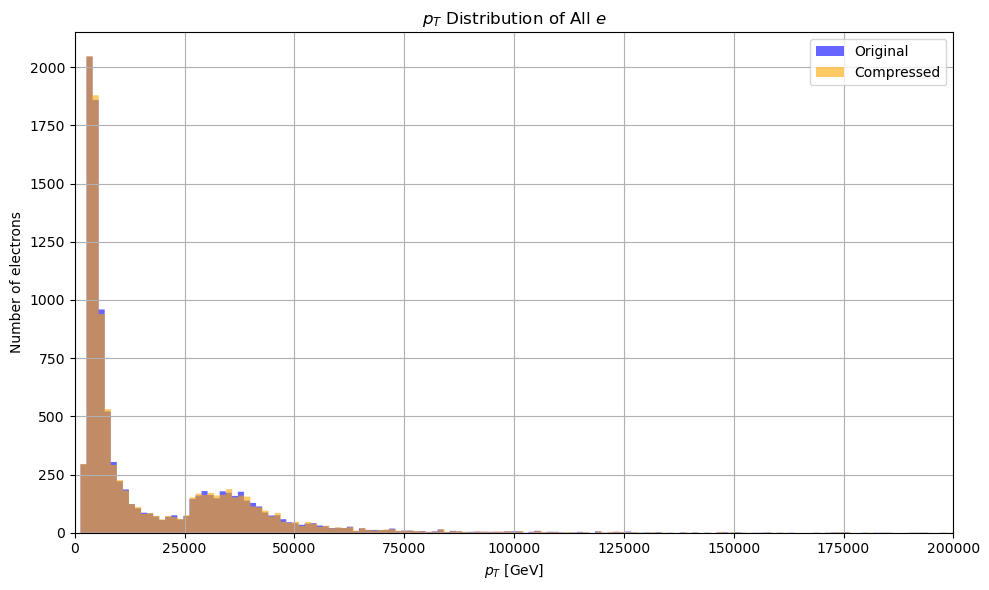

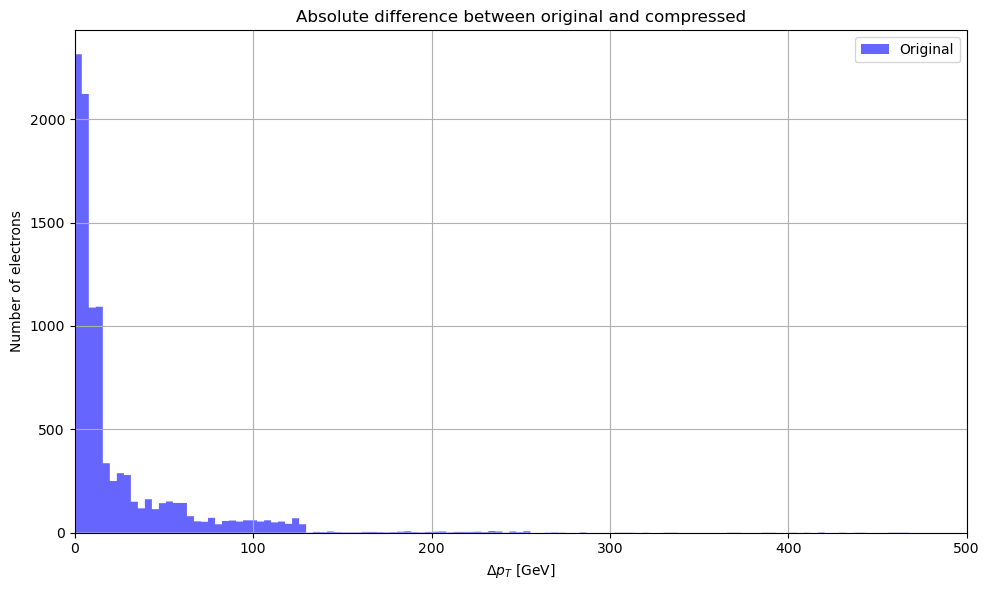

In [16]:
# Load original
tree_orig = uproot.open({filename: "CollectionTree"})
el_pt_orig = tree_orig["AnalysisElectronsAuxDyn.pt"].array()
original = ak.flatten(el_pt_orig).to_numpy()

# Load compressed
tree_comp = uproot.open({compressed: "CollectionTree"})
el_pt_comp = tree_comp["AnalysisElectronsAuxDyn.pt"].array()
compressed = ak.flatten(el_pt_comp).to_numpy()

# Print sizes
print(f'Original: {len(original):,} electrons')
print(f'Compressed: {len(compressed):,} electrons')

# Plot both distributions
plt.figure(figsize=(10, 6))
plt.hist(original, bins=500, alpha=0.6, label='Original', histtype='stepfilled', color='blue')
plt.hist(compressed, bins=500, alpha=0.6, label='Compressed', histtype='stepfilled', color='orange')
plt.title(r'$p_T$ Distribution of All $e$')
plt.xlabel(r'$p_T$ [GeV]')
plt.ylabel('Number of electrons')
plt.xlim(left = 0, right=200000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(np.abs(original-compressed), bins=500, alpha=0.6, label='Original', histtype='stepfilled', color='blue')
plt.title(r'Absolute difference between original and compressed')
plt.xlabel(r'$\Delta p_T$ [GeV]')
plt.ylabel('Number of electrons')
plt.xlim(left = 0, right=500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Log-Scaled Distribution Analysis

Visualize $p_T$ distributions and differences on a logarithmic scale for better insight into compression effects.

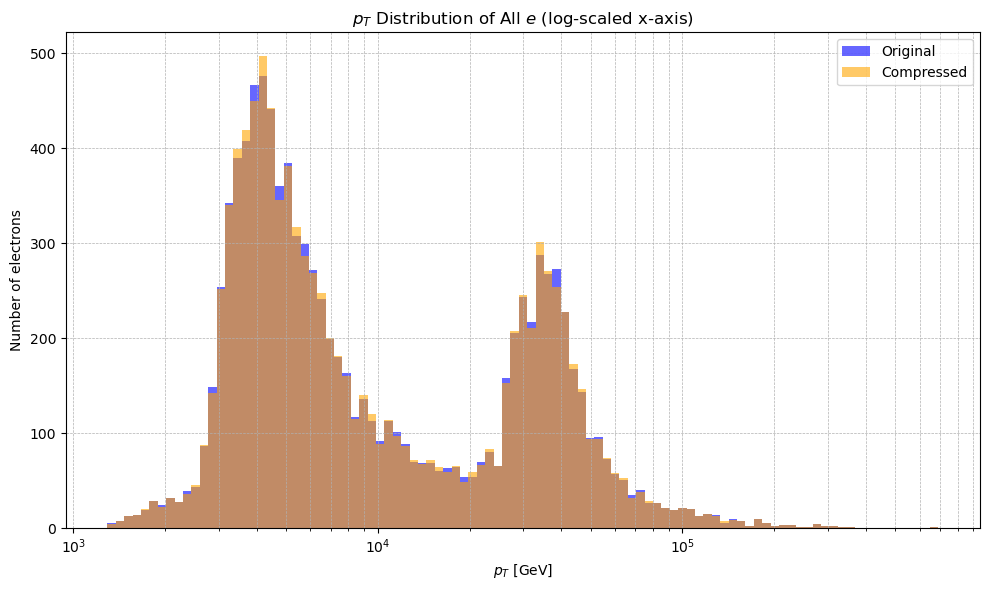

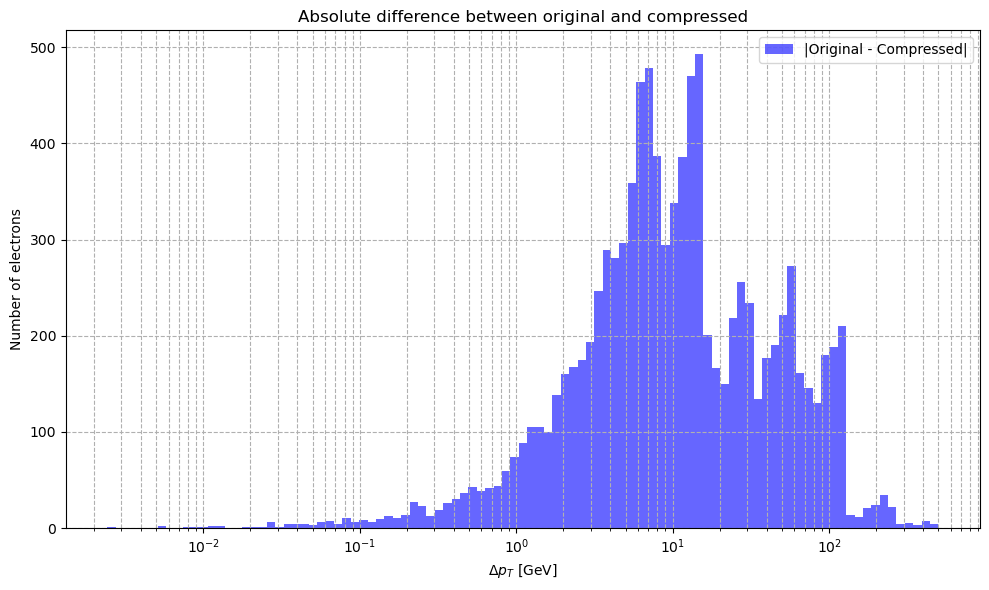

In [17]:
# Compute absolute differences (and avoid zero)
pt_diff_abs = np.abs(original - compressed)
pt_diff_abs = pt_diff_abs[pt_diff_abs > 0]  # remove zeros to avoid log(0)

pt_orig_pos = original[original > 0]
pt_comp_pos = compressed[compressed > 0]

# Get global min and max for log bins
pt_min = min(pt_orig_pos.min(), pt_comp_pos.min())
pt_max = max(pt_orig_pos.max(), pt_comp_pos.max())

# Create log-spaced bins
bins = np.logspace(np.log10(pt_min), np.log10(pt_max), 100)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(pt_orig_pos, bins=bins, alpha=0.6, label='Original', histtype='stepfilled', color='blue')
plt.hist(pt_comp_pos, bins=bins, alpha=0.6, label='Compressed', histtype='stepfilled', color='orange')
plt.xscale('log')
plt.xlabel(r'$p_T$ [GeV]')
plt.ylabel('Number of electrons')
plt.title(r'$p_T$ Distribution of All $e$ (log-scaled x-axis)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

bins = np.logspace(np.log10(pt_diff_abs.min()), np.log10(500), 100)

plt.figure(figsize=(10, 6))
plt.hist(pt_diff_abs, bins=bins, alpha=0.6, label='|Original - Compressed|',
         histtype='stepfilled', color='blue')

plt.xscale('log')  # Set x-axis to log scale
plt.title(r'Absolute difference between original and compressed')
plt.xlabel(r'$\Delta p_T$ [GeV]')
plt.ylabel('Number of electrons')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


## 11. Multi-Variable Distribution Comparison

Compare $p_T$, $\eta$, and $\phi$ distributions for electrons in original and compressed files.

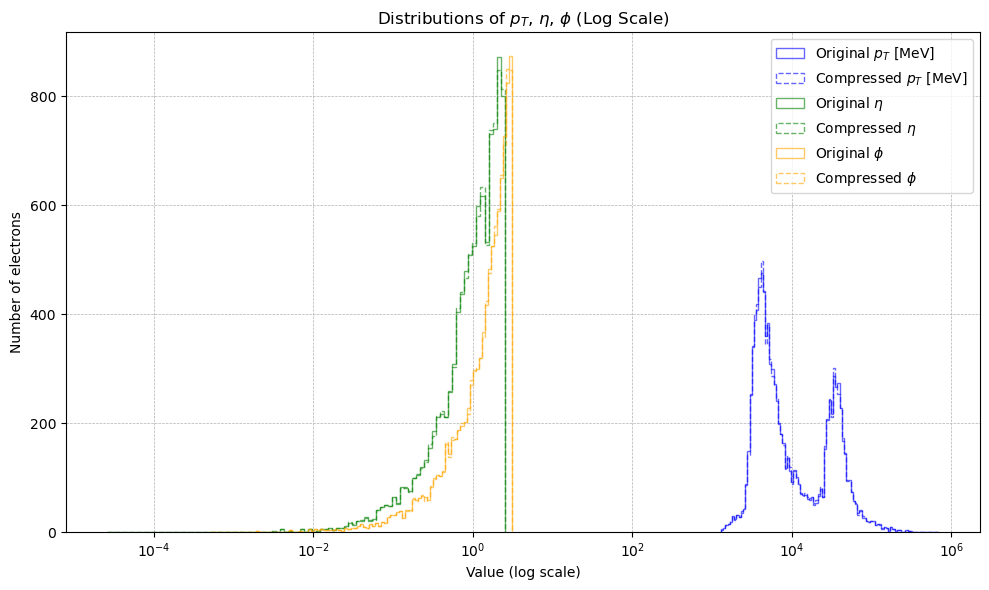

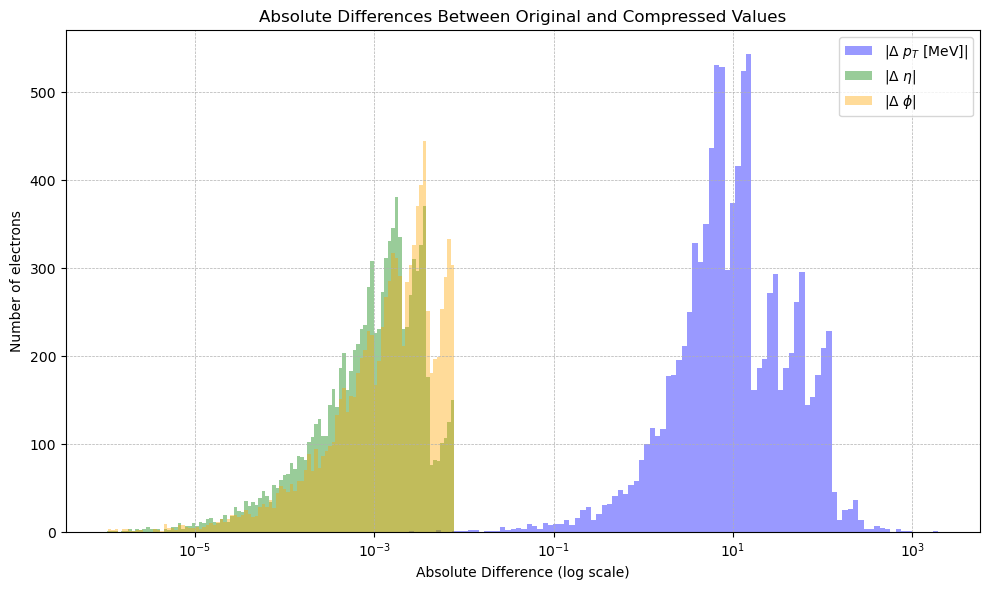

In [31]:
# --- Files ---
tree_orig = uproot.open({filename: "CollectionTree"})
tree_comp = uproot.open({compressed_filename: "CollectionTree"})

# --- Variables to Plot ---
variables = {
    "pt": r"$p_T$ [MeV]",
    "eta": r"$\eta$",
    "phi": r"$\phi$"
}
branch_prefix = "AnalysisElectronsAuxDyn"

# --- Setup storage ---
original_data = {}
compressed_data = {}
abs_diffs = {}

# --- Load and compute differences ---
for var, label in variables.items():
    orig_array = ak.flatten(tree_orig[f"{branch_prefix}.{var}"].array()).to_numpy()
    comp_array = ak.flatten(tree_comp[f"{branch_prefix}.{var}"].array()).to_numpy()

    # Filter valid entries and remove near-zero
    mask = np.isfinite(orig_array) & np.isfinite(comp_array) & (np.abs(orig_array) > 1e-13)
    orig = np.abs(orig_array[mask])
    comp = np.abs(comp_array[mask])
    diff_abs = np.abs(orig - comp)
    diff_abs = diff_abs[diff_abs > 1e-6]  # avoid log(0)

    # Store
    original_data[var] = orig
    compressed_data[var] = comp
    abs_diffs[var] = diff_abs

# --- Colors ---
colors = {"pt": "blue", "eta": "green", "phi": "orange"}

# --- Distributions: Original vs Compressed ---
plt.figure(figsize=(10, 6))
for var, label in variables.items():
    orig = original_data[var]
    comp = compressed_data[var]

    # Define log bins
    combined = np.concatenate([orig, comp])
    minval = max(np.min(combined[combined > 0]), 1e-13)
    maxval = np.max(combined)
    bins = np.logspace(np.log10(minval), np.log10(maxval), 100)

    # Plot both
    plt.hist(orig, bins=bins, histtype='step', color=colors[var], alpha=0.6, label=f"Original {label}")
    plt.hist(comp, bins=bins, histtype='step', color=colors[var], linestyle='--', alpha=0.6, label=f"Compressed {label}")

plt.xscale("log")
plt.xlabel("Value (log scale)")
plt.ylabel("Number of electrons")
plt.title("Distributions of $p_T$, $\\eta$, $\\phi$ (Log Scale)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Absolute Differences ---
plt.figure(figsize=(10, 6))
for var, label in variables.items():
    diff = abs_diffs[var]

    minval = max(np.min(diff[diff > 0]), 1e-13)
    maxval = np.max(diff)
    bins = np.logspace(np.log10(minval), np.log10(maxval), 100)

    plt.hist(diff, bins=bins, histtype='stepfilled', alpha=0.4, color=colors[var], label=f"|Δ {label}|")

plt.xscale("log")
plt.xlabel("Absolute Difference (log scale)")
plt.ylabel("Number of electrons")
plt.title("Absolute Differences Between Original and Compressed Values")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## 12. Peak Detection in Absolute Differences

Detect and analyze peaks in the absolute differences between original and compressed values for each variable.

🔹 $p_T$ [MeV] Peak 1: Value = 6.588e+00, Count = 483
🔹 $p_T$ [MeV] Peak 2: Value = 1.309e+01, Count = 472
🔹 $p_T$ [MeV] Peak 3: Value = 2.602e+01, Count = 247
🔹 $p_T$ [MeV] Peak 4: Value = 5.170e+01, Count = 244
🔹 $p_T$ [MeV] Peak 5: Value = 1.028e+02, Count = 193
🔹 $\eta$ Peak 1: Value = 2.445e-04, Count = 120
🔹 $\eta$ Peak 2: Value = 4.591e-04, Count = 184
🔹 $\eta$ Peak 3: Value = 9.432e-04, Count = 272
🔹 $\eta$ Peak 4: Value = 1.771e-03, Count = 349
🔹 $\eta$ Peak 5: Value = 3.326e-03, Count = 319
🔹 $\phi$ Peak 1: Value = 8.628e-04, Count = 216
🔹 $\phi$ Peak 2: Value = 1.620e-03, Count = 302
🔹 $\phi$ Peak 3: Value = 3.327e-03, Count = 387


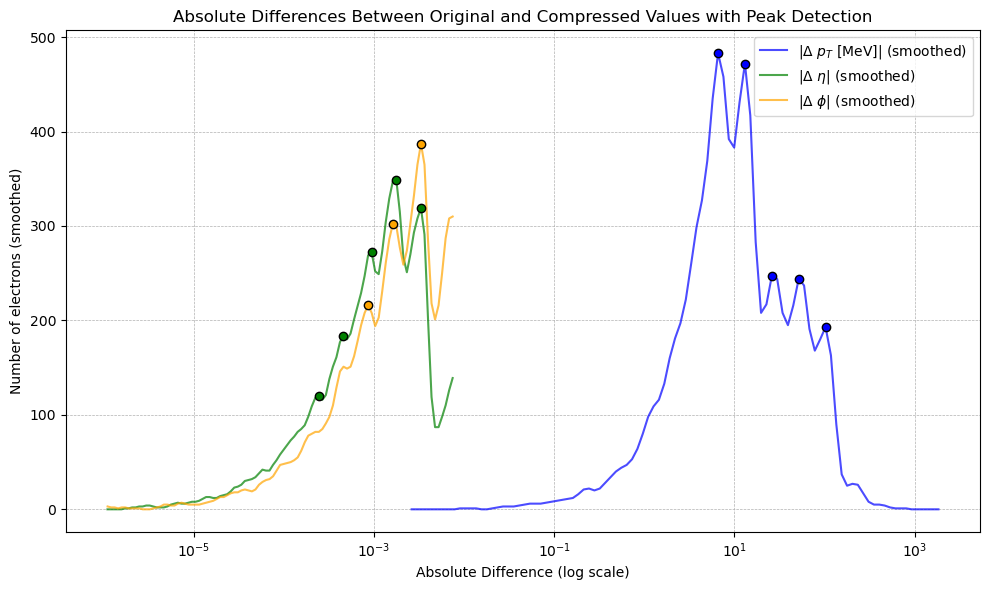


🔍 Log-Scale Peak Spacing Analysis:
  • $p_T$ [MeV]: mean Δlog10 = 0.298, std = 0.000 → ✅ Approx. equidistant
  • $\eta$: mean Δlog10 = 0.283, std = 0.017 → ❌ Not equidistant
  • $\phi$: mean Δlog10 = 0.293, std = 0.020 → ❌ Not equidistant


In [35]:

# --- Absolute Differences with Peak Detection ---
plt.figure(figsize=(10, 6))
log_peak_positions = {}  # new dict to store log10 peak positions
equidistant_vars = []

for var, label in variables.items():
    diff = abs_diffs[var]
    diff = diff[np.isfinite(diff) & (diff > 0)]

    if len(diff) == 0:
        continue

    minval = max(np.min(diff), 1e-13)
    maxval = np.max(diff)
    bins = np.logspace(np.log10(minval), np.log10(maxval), 100)

    hist_vals, bin_edges = np.histogram(diff, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Smooth histogram to reduce noise
    smoothed = gaussian_filter1d(hist_vals, sigma=1)

    # Peak detection
    peaks, _ = find_peaks(smoothed, prominence=0.01 * np.max(smoothed), distance=3)
    log_peaks = np.log10(bin_centers[peaks])
    log_peak_positions[label] = log_peaks
    

    # Plot histogram
    plt.plot(bin_centers, smoothed, color=colors[var], label=f"|Δ {label}| (smoothed)", alpha=0.7)

    # Plot detected peaks
    plt.scatter(bin_centers[peaks], smoothed[peaks], color=colors[var], edgecolor='black', zorder=5)

    # Print peak locations
    for i, p in enumerate(peaks):
        peak_val = bin_centers[p]
        peak_height = smoothed[p]
        print(f"🔹 {label} Peak {i+1}: Value = {peak_val:.3e}, Count = {peak_height:.0f}")

plt.xscale("log")
plt.xlabel("Absolute Difference (log scale)")
plt.ylabel("Number of electrons (smoothed)")
plt.title("Absolute Differences Between Original and Compressed Values with Peak Detection")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

def analyze_peak_spacing(log_peaks_dict):
    print("\n🔍 Log-Scale Peak Spacing Analysis:")
    for var, log_peaks in log_peaks_dict.items():
        if len(log_peaks) < 2:
            print(f"  • {var}: Less than 2 peaks found.")
            continue

        diffs = np.diff(log_peaks)
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)

        is_equidistant = std_diff < 0.05 * mean_diff  # adjustable threshold
        spacing_str = "✅ Approx. equidistant" if is_equidistant else "❌ Not equidistant"
        if is_equidistant:
            equidistant_vars.append(var)

        print(f"  • {var}: mean Δlog10 = {mean_diff:.3f}, std = {std_diff:.3f} → {spacing_str}")

analyze_peak_spacing(log_peak_positions)

## 13. Scatter Plot of Original vs Compressed

Visualize the relationship between original and compressed values using scatter plots.

(10000.0, 50000.0)

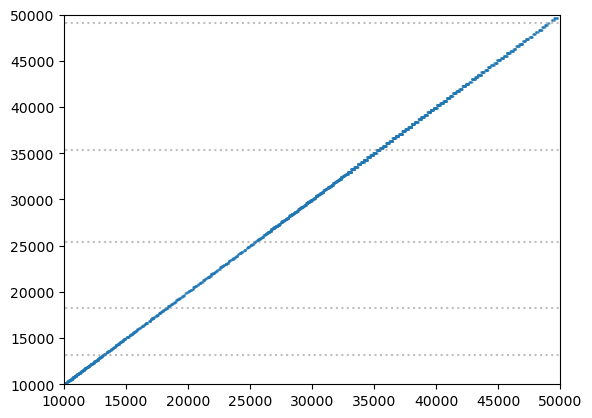

In [43]:
plt.scatter(original, compressed, alpha=0.3, s=1)
steps = np.logspace(np.log10(np.min(original)), np.log10(np.max(original)), num=20, base=10)
plt.hlines(steps, xmin=0, xmax=np.max(original), linestyles="dotted", color='gray', alpha=0.5)
plt.xlim(left=10e3,right=5e4)
plt.ylim(bottom=10e3, top=5e4)

## 14. Statistical Summary of Differences

Compute and display key statistics for the differences between original and compressed electron $p_T$ values.

In [ ]:
# Absolute difference
pt_diff_abs = np.abs(original - compressed)

# Key statistics
min_val = np.min(pt_diff_abs)
max_val = np.max(pt_diff_abs)
mean_val = np.mean(pt_diff_abs)
median_val = np.median(pt_diff_abs)
std_val = np.std(pt_diff_abs)
percentile_95 = np.percentile(pt_diff_abs, 95)
percentile_99 = np.percentile(pt_diff_abs, 99)
num_exact = np.sum(pt_diff_abs == 0)
fraction_exact = num_exact / len(pt_diff_abs)

# Print results
print(f"Absolute $p_T$ difference statistics (GeV):")
print(f"  Min       : {min_val:.6f}")
print(f"  Max       : {max_val:.6f}")
print(f"  Mean      : {mean_val:.6f}")
print(f"  Median    : {median_val:.6f}")
print(f"  Std Dev   : {std_val:.6f}")
print(f"  95th pct  : {percentile_95:.6f}")
print(f"  99th pct  : {percentile_99:.6f}")
print(f"  Exact matches: {num_exact:,} ({fraction_exact:.4%})")

# Avoid division by zero by masking out zero entries
mask_nonzero = original != 0

percent_diff = np.zeros_like(original)
percent_diff[mask_nonzero] = (
    (original[mask_nonzero] - compressed[mask_nonzero])
    / original[mask_nonzero]
) * 100

# Use only non-zero elements for summary
percent_diff_nonzero = percent_diff[mask_nonzero]

print("Percent Difference (Original - Compressed) / Original:")
print(f"  Min       : {np.min(percent_diff_nonzero):.6f}%")
print(f"  Max       : {np.max(percent_diff_nonzero):.6f}%")
print(f"  Mean      : {np.mean(percent_diff_nonzero):.6f}%")
print(f"  Median    : {np.median(percent_diff_nonzero):.6f}%")
print(f"  Std Dev   : {np.std(percent_diff_nonzero):.6f}%")
print(f"  95th pct  : {np.percentile(percent_diff_nonzero, 95):.6f}%")
print(f"  99th pct  : {np.percentile(percent_diff_nonzero, 99):.6f}%")



Absolute $p_T$ difference statistics (GeV):
  Min       : 0.002441
  Max       : 1964.750000
  Mean      : 25.502926
  Median    : 9.876953
  Std Dev   : 47.272305
  95th pct  : 104.650781
  99th pct  : 196.933594
  Exact matches: 0 (0.0000%)
Percent Difference (Original - Compressed) / Original:
  Min       : -0.385840%
  Max       : 0.384385%
  Mean      : -0.000820%
  Median    : -0.000734%
  Std Dev   : 0.165806%
  95th pct  : 0.261536%
  99th pct  : 0.327939%


## 15. Distribution Metrics and Divergences

Evaluate and compare distribution metrics (KL, JS, Wasserstein, MSE, etc.) between original and compressed data.

In [ ]:
def evaluate_and_compare_distributions(data, compressed, output_csv="distribution_stats.csv", bins=100, i=0):
    data = data.flatten()
    compressed = compressed.flatten()
    if i:
        i=str(i)
    else:
        i=""


    # MSE/L1
    mse = np.mean((data - compressed) ** 2)
    l1 = np.mean(np.abs(data - compressed))

    # KL divergence
    hist1, bin_edges = np.histogram(data, bins=bins, density=True)
    hist2, _ = np.histogram(compressed, bins=bin_edges, density=True)
    hist1 += 1e-12
    hist2 += 1e-12
    hist1 /= hist1.sum()
    hist2 /= hist2.sum()
    kl_1_2 = entropy(hist1, hist2)
    kl_2_1 = entropy(hist2, hist1)

    # JS divergence
    js_div = jensenshannon(hist1, hist2)**2

    # Wasserstein
    wass = wasserstein_distance(data, compressed)

    # Per-distribution statistics
    stats = {
        "Metric": ["Mean", "Std Dev", "Variance", "Min", "Max", "Skewness", "Kurtosis"],
        "original data": [
            np.mean(data),
            np.std(data),
            np.var(data),
            np.min(data),
            np.max(data),
            skew(data),
            kurtosis(data),
        ],
        "compressed data": [
            np.mean(compressed),
            np.std(compressed),
            np.var(compressed),
            np.min(compressed),
            np.max(compressed),
            skew(compressed),
            kurtosis(compressed),
        ],
    }

    df = pd.DataFrame(stats)

    # Add comparison metrics
    comparison_metrics = {
        "Metric": [
            "KL(D1||D2)", "KL(D2||D1)", "JS Divergence", "Wasserstein Distance",
            "MSE", "L1 Loss"
        ],
        "original data": [kl_1_2, kl_2_1, js_div, wass, mse, l1],
        "compressed data": ["", "", "", "", "", ""]
    }

    df_compare = pd.DataFrame(comparison_metrics)
    df = pd.concat([df, df_compare], ignore_index=True)

    # Print nicely
    print(f"\n==== {'original data'.upper()} vs {'compressed data'.upper()} ====")
    print(df.to_string(index=False))

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"\nSaved stats to {output_csv}")
    return df

evaluate_and_compare_distributions(original, compressed, output_csv="logs/distribution_stats.csv", bins=100, i=0)


==== ORIGINAL DATA vs COMPRESSED DATA ====
              Metric      original data    compressed data
                Mean      17,932.429688      17,932.433594
             Std Dev      24,870.091797      24,874.369141
            Variance 618,521,472.000000 618,734,272.000000
                 Min       1,299.247559       1,296.000000
                 Max     690,259.250000     692,224.000000
            Skewness           5.637500           5.650031
            Kurtosis          79.484752          80.018994
          KL(D1||D2)           0.001799                   
          KL(D2||D1)           0.000293                   
       JS Divergence           0.000091                   
Wasserstein Distance          25.502923                   
                 MSE       2,885.070068                   
             L1 Loss          25.502926                   

Saved stats to distribution_stats.csv


,Metric,original data,compressed data
0,Mean,"17,932.429688","17,932.433594"
1,Std Dev,"24,870.091797","24,874.369141"
2,Variance,"618,521,472.000000","618,734,272.000000"
3,Min,"1,299.247559","1,296.000000"
4,Max,"690,259.250000","692,224.000000"
5,Skewness,5.637500,5.650031
6,Kurtosis,79.484752,80.018994
7,KL(D1||D2),0.001799,
8,KL(D2||D1),0.000293,
9,JS Divergence,0.000091,


## 16. Histogram Residuals

Plot the residuals between original and compressed histograms to visualize density differences.

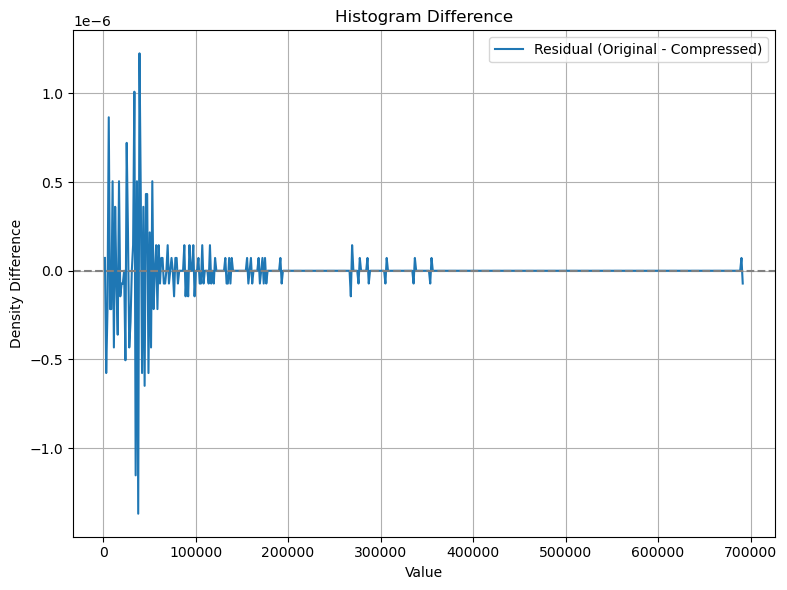

In [ ]:
bins = np.linspace(min(min(original), min(compressed)), max(max(original), max(compressed)), 500)
hist1, _ = np.histogram(original, bins=bins, density=True)
hist2, _ = np.histogram(compressed, bins=bins, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, hist1 - hist2, label='Residual (Original - Compressed)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Value')
plt.ylabel('Density Difference')
plt.title('Histogram Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 17. Empirical CDF Comparison

Compare the empirical cumulative distribution functions (ECDFs) of original and compressed data.

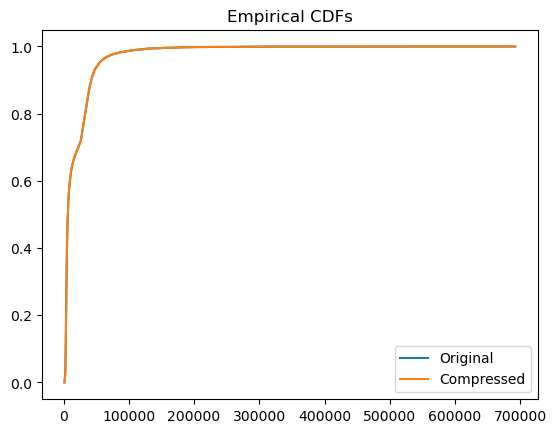

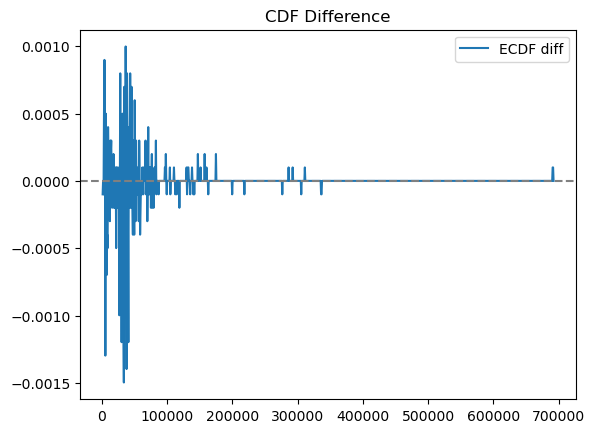

In [ ]:

ecdf1 = ECDF(original)
ecdf2 = ECDF(compressed)
x = np.linspace(min(original.min(), compressed.min()), max(original.max(), compressed.max()), 1000)

plt.plot(x, ecdf1(x), label='Original')
plt.plot(x, ecdf2(x), label='Compressed')
plt.title('Empirical CDFs')
plt.legend()

# Difference plot
plt.figure()
plt.plot(x, ecdf1(x) - ecdf2(x), label='ECDF diff')
plt.axhline(0, color='gray', linestyle='--')
plt.title('CDF Difference')
plt.legend()
